In [1]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

In [2]:
# imports

from src.deep.model_analyzer_src import ModelAnalyzer
from src.deep.data_loaders import DatasetNormal
from src.deep.models import *
from src.deep.trainers import Trainer

from tqdm.notebook import tqdm


In [3]:
# configs
model_name = 'mu-0.125__8000ds__UnetWithSkips__51epochs'
trained_model_path = '../../../data/prod_models/'+model_name
dataset_mu = 0.125
datasetpath = f'../../../data/datasets/qam16_100000x20/100000_samples_mu={dataset_mu}'


In [6]:
# load trainer from file
trainer: Trainer = Trainer.load3(trained_model_path)
ma: ModelAnalyzer = ModelAnalyzer(trainer,model_name)
ma.load_test_dataset(datasetpath, 0.05, 0.03, 0.92)

In [7]:
print(len(trainer.val_dataset))

92000


In [ ]:
print(trainer.val_dataset.config)
mqam = trainer.val_dataset.config.get('m_qam')

In [ ]:
# this part doesnt seem to be essential anymore

# print('paths before:')
# print(trainer.train_dataset.data_dir_path)
# trainer.fix_datasets_paths(new_dataset_path='../../data/datasets', verbose=False)
# print('paths after:')
# print(trainer.train_dataset.data_dir_path)

/home/yarcoh/miniconda3/envs/thesis-code/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


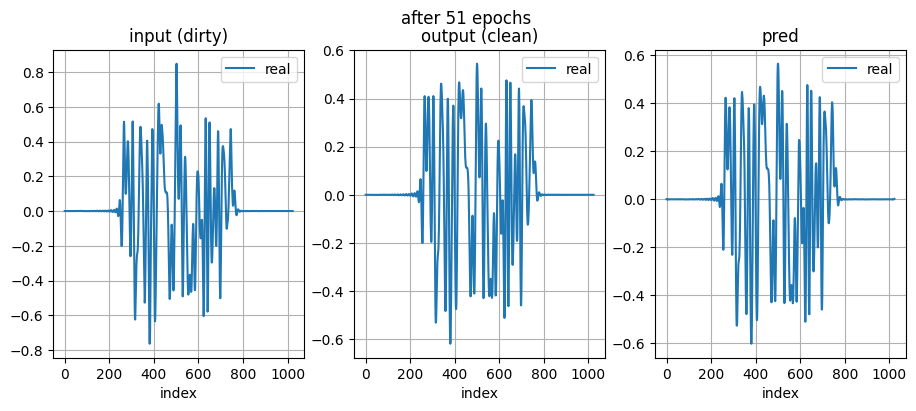

In [8]:
ma.plot_single_item(1)

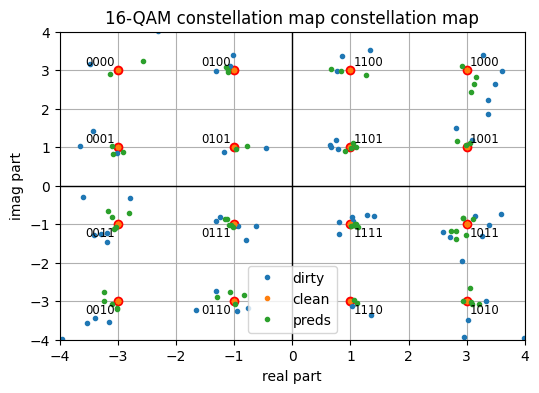

In [9]:
ma.plot_constelation(1)

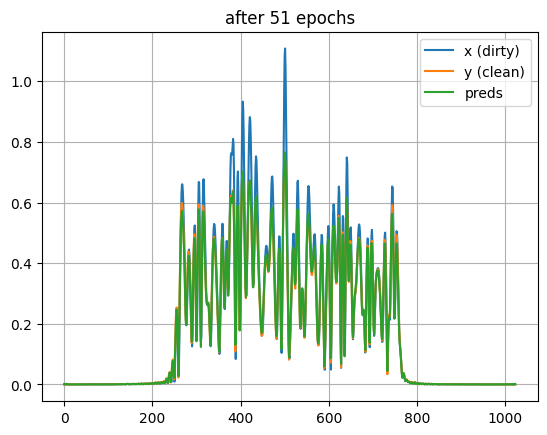

In [10]:
ma.plot_single_item_together(1)

In [12]:
x_power, y_power, pred_power = ma.calc_norms(_tqdm=tqdm, verbose_level=1, max_items=10000)
print(f'x_power: {x_power}\ny_power: {y_power}\npred_power: {pred_power}')

  0%|          | 0/10000 [00:00<?, ?it/s]

x_power: 96.76576547622676
y_power: 78.98803440857041
pred_power: 78.63046861114451


In [ ]:
ma.upload_single_item_plots_to_wandb(1)

In [13]:
ma.plot_bers(_tqdm=tqdm, verbose_level=1)

  0%|          | 0/92000 [00:00<?, ?it/s]

the original avg ber (of validation set) is 0.0006591372282608696


  0%|          | 0/92000 [00:00<?, ?it/s]

the trained avg ber (of validation set) is 0.0
the ber improvement is 100.00%


In [ ]:
ma.upload_bers_to_wandb()

In [ ]:
# print model's architecture
# TODO - make sure every model has this method (make abstract model class that all inherit from)
# trainer.model.print_architecture

# THE END

In [ ]:
# paper 1 model analyzer
path_init = '../../data/test_models/mu-0.008__128ds__PaperNNforNFTmodel__3epochs'

trainer_real = Trainer.load3(path_init + '__real')
trainer_imag = Trainer.load3(path_init + '__imag')

train_ds = SingleMuDataSet(trainer_real.train_dataset.data_dir_path,
                           trainer_real.train_dataset.data_indices)
val_ds = SingleMuDataSet(trainer_real.val_dataset.data_dir_path,
                         trainer_real.val_dataset.data_indices)

model = PaperNNforNFTwrapper(trainer_real.model, trainer_imag.model)

trainer = Trainer(
    train_dataset=train_ds,
    val_dataset=val_ds,
    model=model,
    device=trainer_real.device,
    batch_size=trainer_real.train_dataloader.batch_size,
    l_metric=trainer_real.l_metric,
    optim=trainer_real.optim,
    params=trainer_real.params)

In [ ]:
# analyze on the whole dataset

# attach new dataset to trainer


In [ ]:
trainer.params

In [ ]:
ma = ModelAnalyzer(trainer)

In [ ]:
ma.plot_single_item(i=0)

In [ ]:
ma.plot_bers(_tqdm=tqdm)